In [2]:
# Fill in your API token:
sapi_token = ''

In [3]:
# import necessary packages
from sklearn import preprocessing, metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets.mldata import fetch_mldata
from sklearn.datasets import load_breast_cancer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import warnings
warnings.filterwarnings('ignore')

from qboost import WeakClassifiers, QBoostClassifier, QboostPlus

In [4]:
import glob
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [8]:
hot_dogs = glob.glob('./hot-dog-not-hot-dog/train/hot_dog/*.jpg')
not_hot_dogs = glob.glob('./hot-dog-not-hot-dog/train/not_hot_dog/*.jpg')
hot_dogs_test = glob.glob('./hot-dog-not-hot-dog/test/hot_dog/*.jpg')
not_hot_dogs_test = glob.glob('./hot-dog-not-hot-dog/test/not_hot_dog/*.jpg')

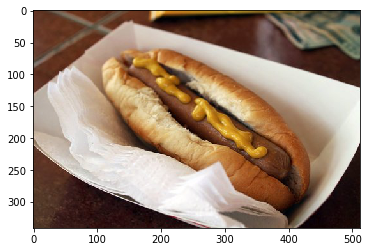

In [9]:
plt.imshow(imread(hot_dogs[0]));

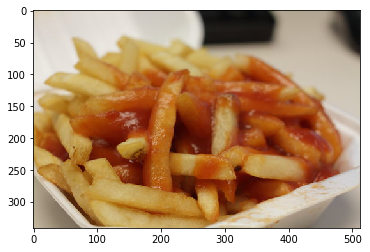

In [10]:
plt.imshow(imread(not_hot_dogs[0]));

In [11]:
# Define the functions required in this example
def metric(y, y_pred):
    """
    :param y: true label
    :param y_pred: predicted label
    :return: metric score
    """

    return metrics.accuracy_score(y, y_pred)


def train_model(X_train, y_train, X_test, y_test, lmd):
    """
    :param X_train: training data
    :param y_train: training label
    :param X_test: testing data
    :param y_test: testing label
    :param lmd: lambda used in regularization
    :return:
    """

    # define parameters used in this function
    NUM_READS = 1000
    NUM_WEAK_CLASSIFIERS = 30
    TREE_DEPTH = 2
    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 'num_spin_reversal_transforms': 10,
                 'postprocess': 'optimization',
                 }

    # define sampler
    dwave_sampler = DWaveSampler(token=sapi_token)
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)
    print("\n======================================")
    print("Train size: %d, Test size: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)

    # Preprocessing data
    imputer = preprocessing.Imputer()
    scaler = preprocessing.StandardScaler()
    normalizer = preprocessing.Normalizer()

    X_train = scaler.fit_transform(X_train)
    X_train = normalizer.fit_transform(X_train)

    X_test = scaler.fit_transform(X_test)
    X_test = normalizer.fit_transform(X_test)

    ## Adaboost
    print('\nAdaboost')
    clf1 = AdaBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS)
    clf1.fit(X_train, y_train)
    y_train1 = clf1.predict(X_train)
    y_test1 = clf1.predict(X_test)
#     print(clf1.estimator_weights_)
    print('accu (train): %5.2f'%(metric(y_train, y_train1)))
    print('accu (test): %5.2f'%(metric(y_test, y_test1)))

    # Ensembles of Decision Tree
    print('\nDecision tree')
    clf2 = WeakClassifiers(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf2.fit(X_train, y_train)
    y_train2 = clf2.predict(X_train)
    y_test2 = clf2.predict(X_test)
#     print(clf2.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test2)))
    
    # Random forest
    print('\nRandom Forest')
    clf3 = RandomForestClassifier(max_depth=TREE_DEPTH, n_estimators=NUM_WEAK_CLASSIFIERS)
    clf3.fit(X_train, y_train)
    y_train3 = clf3.predict(X_train)
    y_test3 = clf3.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train3)))
    print('accu (test): %5.2f' % (metric(y_test, y_test3)))

    # Qboost
    print('\nQBoost')
    clf4 = QBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf4.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print(clf4.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))

    # QboostPlus
    print('\nQBoostPlus')
    clf5 = QboostPlus([clf1, clf2, clf3, clf4])
    clf5.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train5 = clf5.predict(X_train)
    y_test5 = clf5.predict(X_test)
    print(clf5.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train5)))
    print('accu (test): %5.2f' % (metric(y_test, y_test5)))

    print("===========================================================================")
    print("Method \t Adaboost \t DecisionTree \t RandomForest \t Qboost \t Qboost+")
    print("Train\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_train, y_train1),
                                                                         metric(y_train, y_train2),
                                                                         metric(y_train, y_train3),
                                                                         metric(y_train, y_train4),
                                                                         metric(y_train, y_train5),
                                                                        ))
    print("Test\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_test, y_test1),
                                                                       metric(y_test, y_test2),
                                                                       metric(y_test, y_test3),
                                                                       metric(y_test, y_test4),
                                                                       metric(y_test, y_test5)))
    print("===========================================================================")
    
    return [clf1, clf2, clf3, clf4, clf5]

In [12]:
# Currently not using this
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [13]:
# Build training sets
features = hot_dogs + not_hot_dogs
x_train = [cv2.resize(imread(img),(32,32)).ravel() for img in features]
y_train = [1 for hot_dog in hot_dogs]+[0 for not_dog in not_hot_dogs]

In [14]:
# Build test sets
test_features = hot_dogs_test + not_hot_dogs_test
y_test = [1 for hot_dog in hot_dogs_test]+[0 for not_dog in not_hot_dogs_test]
x_test = [cv2.resize(imread(img),(32,32)).ravel() for img in test_features]

In [15]:
clfs = train_model(np.array(x_train),
                   np.array(y_train).astype('uint8'),
                   np.array(x_test),
                   np.array(y_test).astype('uint8'),
                   1.0)


Train size: 498, Test size: 500
Num weak classifiers: 30

Adaboost
accu (train):  0.92
accu (test):  0.58

Decision tree
accu (train):  0.73
accu (test):  0.52

Random Forest
accu (train):  0.74
accu (test):  0.60

QBoost
[1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0]
accu (train):  0.49
accu (test):  0.44

QBoostPlus
[1 1 1 1]
accu (train):  0.50
accu (test):  0.46
Method 	 Adaboost 	 DecisionTree 	 RandomForest 	 Qboost 	 Qboost+
Train	  0.92 		  0.73 		  0.74 		  0.49 		  0.50
Test	  0.58 		  0.52 		  0.60 		  0.44 		  0.46
